# Trader Performance vs Market Sentiment Analysis
Primetrade.ai – Round 0 Assignment

Author: Meenakshi Sahu

Importing the libraries requires

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

Loading the datasets

In [3]:
sentiment = pd.read_csv('/content/drive/MyDrive/fear_greed_index.csv')
trades = pd.read_csv('/content/drive/MyDrive/historical_data.csv')


# **Part A — Data Preparation**

trader dataset

In [4]:
#number of rows/columns
print("Trades Shape: ",trades.shape)

print("\nColumns",trades.columns)



Trades Shape:  (211224, 16)

Columns Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [5]:
#missing values / duplicates
print("\nMissing Values:\n", trades.isnull())
print("\nDuplicate Rows:", trades.duplicated())


Missing Values:
         Account   Coin  Execution Price  Size Tokens  Size USD   Side  \
0         False  False            False        False     False  False   
1         False  False            False        False     False  False   
2         False  False            False        False     False  False   
3         False  False            False        False     False  False   
4         False  False            False        False     False  False   
...         ...    ...              ...          ...       ...    ...   
211219    False  False            False        False     False  False   
211220    False  False            False        False     False  False   
211221    False  False            False        False     False  False   
211222    False  False            False        False     False  False   
211223    False  False            False        False     False  False   

        Timestamp IST  Start Position  Direction  Closed PnL  \
0               False           False    

In [6]:
#total missing and duplicate values
print("\nMissing Values:\n", trades.isnull().sum())

print("\nDuplicate Rows:", trades.duplicated().sum())



Missing Values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicate Rows: 0


Hence there areno missing values or duplicate values present in the trades dataset i.e no missing timestamps,no missing Pnl,no duplicate trades etc.

In [7]:
#Timestamp Alignment

#converting to pandas datetime format
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)

#extrating the date as time is not needed
trades['date'] = trades['Timestamp IST'].dt.date

#converting the python obj back to pd for standardization of comparison time now in all 00:00:00
trades['date'] = pd.to_datetime(trades['date'])

# Keep only needed columns
sentiment = sentiment[['date', 'classification']].drop_duplicates(subset='date')

# Check date ranges
print("Trade date range:", trades['date'].min(), "to", trades['date'].max())
print("Sentiment date range:", sentiment['date'].min(), "to", sentiment['date'].max())
print("\nUnique trading days:", trades['date'].nunique())


Trade date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Sentiment date range: 2018-02-01 to 2025-05-02

Unique trading days: 480


Key metrics evaluation

In [8]:
#Daily PnL per Trader

# Group the trades data by Account and date
daily_pnl = trades.groupby(['Account', 'date'])['Closed PnL'].sum().reset_index()

# After summing, the column is still named 'Closed PnL, we rename it to daily_pnl'
daily_pnl.rename(columns={'Closed PnL': 'daily_pnl'}, inplace=True)


In [13]:
#Win rate = percentage of profitable trades that day.
trades['win'] = trades['Closed PnL'] > 0

''' Group by Account and date
 For each trader and each day, calculate the mean of the 'win' column
 mean() gives the percentage of profitable trades that day'''
daily_win = trades.groupby(['Account', 'date'])['win'].mean().reset_index()

daily_win.rename(columns={'win': 'win_rate'}, inplace=True)

In [14]:
#Average Trade Size (USD)
daily_size = trades.groupby(['Account', 'date'])['Size USD'].mean().reset_index()
daily_size.rename(columns={'Size USD': 'avg_trade_size'}, inplace=True)


In [15]:
#leverage distribution

print(trades.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'win'],
      dtype='object')


levarage column not available hene can not approximate it

In [16]:
#Number of Trades per Day (Trading frequency)
daily_trades = trades.groupby(['Account', 'date']).size().reset_index(name='trades_per_day')

In [17]:
#Total Volume Traded per Day (Total exposure)
daily_volume = trades.groupby(['Account', 'date'])['Size USD'].sum().reset_index()
daily_volume.rename(columns={'Size USD': 'total_volume_usd'}, inplace=True)



In [18]:
#Long / Short Ratio (Directional bias)
trades['is_long'] = trades['Side'].str.upper().isin(['BUY'])

daily_long_ratio = trades.groupby(['Account', 'date'])['is_long'].mean().reset_index()
daily_long_ratio.rename(columns={'is_long': 'long_ratio'}, inplace=True)


In [19]:
# 🔹 Merge all metrics
from functools import reduce

dfs = [daily_pnl,daily_win,daily_size,daily_trades,daily_volume, daily_long_ratio]

daily_metrics = reduce(lambda left,right:pd.merge(left, right, on=['Account','date']), dfs)

print("Daily metrics shape:", daily_metrics.shape)
daily_metrics.head()

Daily metrics shape: (2341, 8)


,Account,date,daily_pnl,win_rate,avg_trade_size,trades_per_day,total_volume_usd,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.000000,5089.718249,177,900880.13,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,0.000000,7976.664412,68,542413.18,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,0.000000,23734.500000,40,949380.00,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,0.000000,28186.666667,12,338240.00,1.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,0.444444,17248.148148,27,465700.00,0.444444


In [20]:
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

merged = daily_metrics.merge(sentiment, on='date', how='left')

print("Final shape:", merged.shape)
print("Missing sentiment rows:", merged['classification'].isnull().sum())


Final shape: (2341, 9)
Missing sentiment rows: 1


In [21]:
merged = merged.dropna(subset=['classification'])

print("Final cleaned shape:", merged.shape)

Final cleaned shape: (2340, 9)


# **PART B — Analysis**

1. Does Performance Differ Between Fear vs Greed Days?

In [22]:
performance_summary = (
    merged
    .groupby('classification')[['daily_pnl', 'win_rate']]
    .agg(['mean', 'median', 'std'])
)

performance_summary




daily_pnl                            win_rate            \
                       mean      median           std      mean    median   
classification                                                              
Extreme Fear    4619.439053  218.377399  29534.839183  0.329659  0.307738   
Extreme Greed   5161.922644  418.319862  27496.863832  0.386387  0.357143   
Fear            5328.818161  107.892532  31659.771538  0.364033  0.315302   
Greed           3318.100730  158.214922  30599.040173  0.343559  0.289182   
Neutral         3438.618818  167.551743  17447.863645  0.355414  0.321091   

                          
                     std  
classification            
Extreme Fear    0.320043  
Extreme Greed   0.343814  
Fear            0.353571  
Greed           0.343731  
Neutral         0.333569

Yes, performance clearly changes across sentiment regimes and specifically btween greed and fear.

Extreme Greed has the highest win rates and stronger median profits, which suggests traders perform better in momentum-driven markets.

Fear shows the highest PnL volatility, meaning performance is more unstable and risk exposure is higher.

Neutral regimes have much lower volatility (~17k vs 30k+), indicating calmer and more stable outcomes, even if profits aren’t the highest.

2. Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?


In [23]:
behavior_summary = (merged.groupby('classification')[['trades_per_day','avg_trade_size','total_volume_usd','long_ratio']] .mean())

behavior_summary


,trades_per_day,avg_trade_size,total_volume_usd,long_ratio
classification,,,,
Extreme Fear,133.750000,6773.464125,715526.634000,0.531533
Extreme Greed,76.030418,5371.637182,236625.788156,0.473116
Fear,98.153968,8975.928546,767182.206016,0.518967
Greed,77.628086,6427.866594,445343.356049,0.471594
Neutral,100.228723,6963.694861,479367.189043,0.472431


Insights on behaviour changes based on sentiments

>>Insight 1

Trade frequency increases significantly during Fear regimes (133 trades/day vs 76 in Extreme Greed), indicating reactive or volatility-driven trading behavior.

>>Insight 2

Average trade size and total volume are highest during Fear periods, suggesting elevated risk appetite rather than defensive positioning.

>>Insight 3

Long bias increases during Fear (~53%), implying traders attempt to capture rebounds or bottom reversals during pessimistic market conditions.

 3. Identify segments

In [24]:
#segment 1
#frequent vs infrequent traders
median_trades = merged['trades_per_day'].median()

merged['frequency_segment'] = merged['trades_per_day'].apply(
    lambda x: 'High Frequency' if x > median_trades else 'Low Frequency'
)


In [25]:
merged.groupby(['classification', 'frequency_segment'])['daily_pnl'].mean()


classification  frequency_segment
Extreme Fear    High Frequency        6799.753651
                Low Frequency          457.020275
Extreme Greed   High Frequency        8437.437459
                Low Frequency         1627.473851
Fear            High Frequency       10311.492505
                Low Frequency          913.034911
Greed           High Frequency        5486.377107
                Low Frequency         1401.949513
Neutral         High Frequency        5759.162182
                Low Frequency         1118.075454
Name: daily_pnl, dtype: float64

Insight 1

High-frequency traders significantly outperform low-frequency traders across all sentiment regimes. During Fear periods, high-frequency accounts generate over 10x higher average daily PnL, indicating superior ability to capitalize on volatile market conditions.

In [26]:
#segment 2
#consistent winners vs inconsistent traders
account_avg = merged.groupby('Account')['daily_pnl'].mean()

profitable_accounts = account_avg[account_avg > 0].index

merged['consistency_segment'] = merged['Account'].apply(
    lambda x: 'Consistent Winner' if x in profitable_accounts else 'Inconsistent'
)


In [27]:
merged.groupby(['classification','consistency_segment'])['daily_pnl'].mean()


classification  consistency_segment
Extreme Fear    Consistent Winner       5251.080111
                Inconsistent           -1967.674838
Extreme Greed   Consistent Winner       5338.976051
                Inconsistent             682.471435
Fear            Consistent Winner       5495.169303
                Inconsistent            3479.761239
Greed           Consistent Winner       4243.154168
                Inconsistent          -14489.177956
Neutral         Consistent Winner       3647.197298
                Inconsistent             942.869417
Name: daily_pnl, dtype: float64

Insight 2

Consistent traders maintain profitability across regimes.
Inconsistent traders suffer severe losses in Greed regimes.

Chart 1 — Frequency Segment

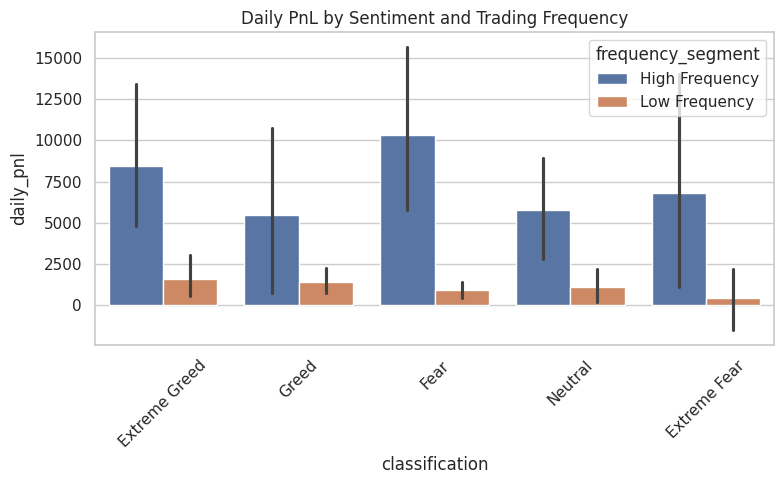

In [28]:
plt.figure(figsize=(8,5))
sns.barplot(data=merged,
            x='classification',
            y='daily_pnl',
            hue='frequency_segment')

plt.title("Daily PnL by Sentiment and Trading Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Chart 2 — Consistency Segment

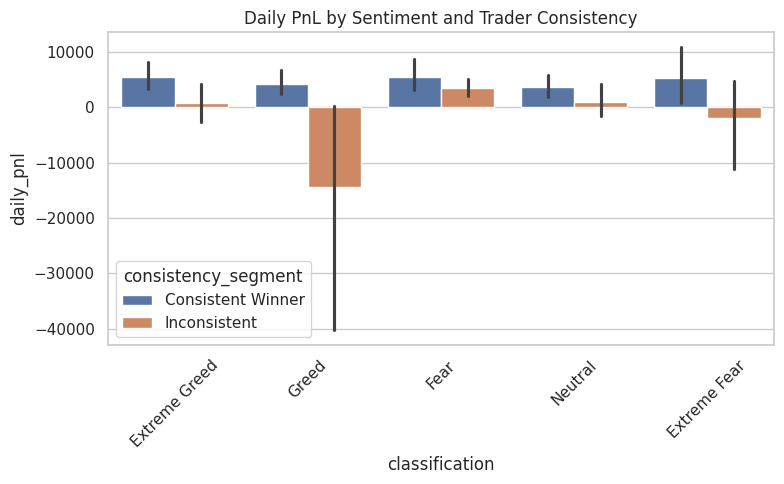

In [29]:
plt.figure(figsize=(8,5))
sns.barplot(data=merged,
            x='classification',
            y='daily_pnl',
            hue='consistency_segment')

plt.title("Daily PnL by Sentiment and Trader Consistency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


>>Insight 1 (Frequency)

High-frequency traders significantly outperform low-frequency traders across all regimes, with the largest gap during Fear markets.

>>Insight 2 (Regime Sensitivity)

Greed regimes create the largest performance dispersion between consistent and inconsistent traders, with inconsistent traders suffering severe losses.

>>Insight 3 (Volatility Connection)

Fear regimes amplify both trading activity and PnL dispersion, indicating volatility-driven profit opportunities for skilled traders.

# **PART C- STRATEGIES**

**Strategy Idea 1**

EVIDENCE FROM ANALYSIS STATES :

1.Inconsistent traders experience large negative PnL during Greed (~ −14k).
2.Performance gap between consistent and inconsistent traders is largest in Greed.

ACTIONS TO TAKE:

During Greed regimes, reduce position size or tighten stop-loss thresholds for traders with historically inconsistent performance.

REASONING:

Greed appears to be a regime where optimism leads to large losses for weaker traders.
So risk controls should be stricter when sentiment is optimistic.

**Strategy Idea 2**

EVIDENCE FROM ANALYSIS STATES:

1.Fear regimes show higher trade frequency and higher PnL dispersion.

2.High-frequency traders generate significantly higher returns during Fear.

3.Fear has highest volatility (std ≈ 31k).

ACTIONS TO TAKE

During Fear regimes, allow increased trading frequency for historically high-frequency or consistent traders, while maintaining capped exposure for low-frequency accounts.

REASONING

Fear regimes appear volatility-rich environments where skilled active traders thrive.
But weaker traders should not increase risk blindly.


# Bonus-: Clustering Traders into Behavioral Archetypes

In [30]:
#cluster traders based on their average behavior.
account_features = merged.groupby('Account')[[
    'trades_per_day',
    'avg_trade_size',
    'long_ratio',
    'daily_pnl'
]].mean()


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(account_features)


In [32]:
#using k means k=3
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
account_features['cluster'] = kmeans.fit_predict(scaled_data)


In [33]:
cluster_summary = account_features.groupby('cluster').mean()
cluster_summary


,trades_per_day,avg_trade_size,long_ratio,daily_pnl
cluster,,,,
0,194.057794,13273.589325,0.578875,6520.090500
1,51.161736,4215.222492,0.408902,4257.104987
2,159.083333,33569.102224,0.492173,66676.242499


In [35]:
account_features['cluster'].value_counts()


,count
cluster,
1,18
0,13
2,1


Behavioral Archetypes

Clustering analysis identified distinct behavioral archetypes, suggesting potential for regime-based capital allocation frameworks.

Evidence: Clustering reveals two dominant archetypes: high-frequency active traders and low-frequency conservative traders. A single high-capital outlier account contributes disproportionate returns.
Interpretation: Profitability is concentrated among active or capital-intensive accounts.
Implication: Strategy allocation should consider trader type.